In [1]:
import calour as ca 
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from os.path import exists

/home/software/anaconda3/envs/qiime2-2022.2/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_repeats=1, random_state=None as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/software/anaconda3/envs/qiime2-2022.2/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=3, n_repeats=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [2]:
pd.set_option('max_colwidth',500)
pd.set_option('max_rows',500)

# loading data

In [5]:
tab = ca.read_amplicon('conqur-adjusted-table-rarefied17794.biom',
                       'metadata.txt',
                       normalize=100,min_reads=None)
tab

AmpliconExperiment ("conqur-adjusted-table-rarefied17794.biom") with 1059 samples, 4192 features

In [6]:
tab.sample_metadata.head(2)

,sample_type,project_ID,sequencing_region,diagnose,age,gender,BMI,tumor_site,T_stage,N_stage,...,sequencing_region_merge,host_replicates,treatment_yn,replicate_2,HNSCC,_sample_id,_calour_original_abundance,observed_features,shannon_entropy,faith_pd
sample-id,,,,,,,,,,,,,,,,,,,,,
SRR21105746,Oral_rinse,PRJNA870048,V3-V4,OSCC,63.0,M,NaN,tongue,NaN,NaN,...,V3-V4,NaN,NaN,NaN,NaN,SRR21105746,17794.0,184,3.804584,16.04912
SRR6110936,Saliva,PRJNA412445,V4-V5,OSCC,63.0,F,NaN,NaN,II,0,...,V4-V5,NaN,NaN,NaN,NaN,SRR6110936,17794.0,177,4.731407,18.01963


## filtering

In [7]:
tab = tab.filter_samples('gender', np.nan, negate=True)
tab

AmpliconExperiment ("conqur-adjusted-table-rarefied17794.biom") with 873 samples, 4192 features

In [8]:
tab.sample_metadata.pivot_table(values='_sample_id',index='project_ID',columns='diagnose',aggfunc='count')

diagnose,Healthy_control,OPMD,OSCC
project_ID,,,
OEP000837,NaN,NaN,31.0
PRJEB37501,NaN,28.0,45.0
PRJEB39064,25.0,21.0,27.0
PRJNA386665,127.0,123.0,124.0
PRJNA412445,NaN,NaN,16.0
PRJNA421234,NaN,NaN,14.0
PRJNA700849,8.0,NaN,2.0
PRJNA751046,9.0,NaN,9.0
PRJNA756784,39.0,NaN,19.0


In [9]:
# filter OPMD samples
tab_f = tab.filter_samples(
    'diagnose', ['Healthy_control','OSCC']).filter_abundance(0.0001)
tab_f

AmpliconExperiment ("conqur-adjusted-table-rarefied17794.biom") with 701 samples, 3524 features

In [11]:
df = tab_f.sample_metadata.pivot_table(values='_sample_id',index='gender',columns='diagnose',aggfunc='count')
df['total_samples'] = df.sum(axis=1)
df

diagnose,Healthy_control,OSCC,total_samples
gender,,,
F,56,74,130
M,242,329,571


## gender distribution

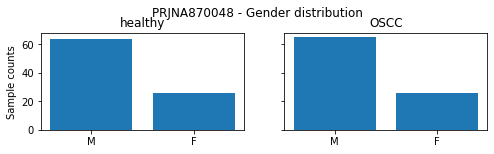

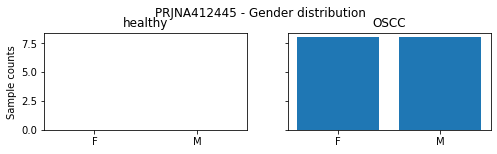

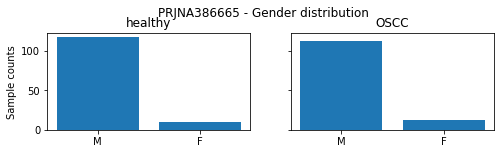

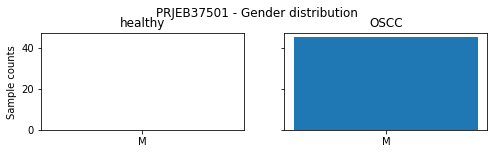

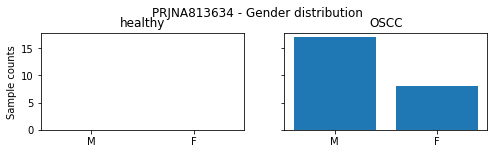

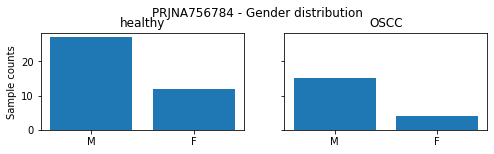

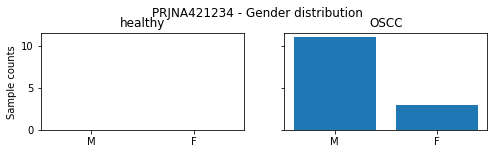

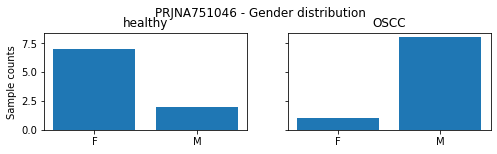

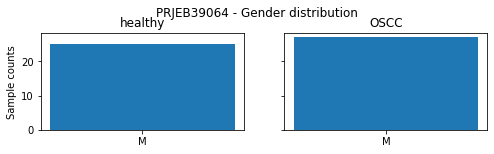

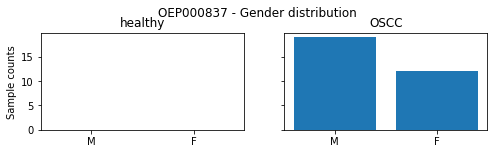

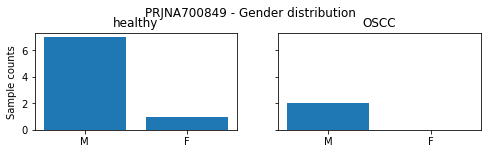

In [13]:
# age distribution in treatments in each study
for prj in tab_f.sample_metadata['project_ID'].unique():
    exp_a = tab_f.filter_samples('project_ID', prj).filter_abundance(
        0.01).filter_prevalence(0.1, cutoff=0.0001)
    exp_a_hc = exp_a.filter_samples('diagnose', 'Healthy_control')
    exp_a_oscc = exp_a.filter_samples('diagnose', 'OSCC')
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 2), 
                         sharex=True, sharey=True)
    df = exp_a_hc.sample_metadata['gender'].value_counts()
    axes[0].bar(df.index, df.values)
    axes[0].set_title('healthy')
    axes[0].set_ylabel('Sample counts')
    df = exp_a_oscc.sample_metadata['gender'].value_counts()
    axes[1].bar(df.index, df.values)
    axes[1].set_title('OSCC')
    plt.suptitle('%s - Gender distribution' % prj)
    plt.subplots_adjust(top=0.8)

# gender prediction

In [328]:
tab_f.sample_metadata['gender_01'] = tab_f.sample_metadata['gender'].replace({'M':1, 'F':0})

In [329]:
tab_f_hc = tab_f.filter_samples('diagnose', 'Healthy_control')
tab_f_oscc = tab_f.filter_samples('diagnose', 'OSCC')
tab_f_hc, tab_f_oscc

(AmpliconExperiment ("conqur-adjusted-table-rarefied17794.biom") with 298 samples, 3524 features,
 AmpliconExperiment ("conqur-adjusted-table-rarefied17794.biom") with 403 samples, 3524 features)

## RF hyperparameter tuning

In [333]:
rf = RandomForestClassifier(random_state=random_state)

In [20]:
# model hyperparameters by random search method
params = {
    'n_estimators': [1000],
    'criterion': ["gini", "entropy"],
    'max_depth': [None, 5, 10, 20, 50], # The maximum depth of the tree
    'min_samples_split': [2, 5, 10], # The minimum number of samples required to split an internal node, default=2.
    'min_samples_leaf': [1, 2, 5, 10], # The minimum number of samples required to be at a leaf node, default=1.
    'max_features': ['sqrt', 'log2', None],
    'max_leaf_nodes': [None], # If None then unlimited number of leaf nodes.
    'bootstrap': [True],
}

rf_randomized_search = model_selection.RandomizedSearchCV(estimator=rf,
                                                       param_distributions=params,
                                                       cv = 5,
                                                       scoring='roc_auc',
                                                       verbose=1)

rf_randomized_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1234),
                   param_distributions={'bootstrap': [True],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 5, 10, 20, 50],
                                        'max_features': ['sqrt', 'log2', None],
                                        'max_leaf_nodes': [None],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [1000]},
                   scoring='roc_auc', verbose=1)

In [334]:
rf_randomized_search.best_estimator_

RandomForestClassifier(max_depth=20, max_features=None, min_samples_leaf=10,
                       min_samples_split=5, n_estimators=1000,
                       random_state=1234)

## prediction 

In [432]:
rf = RandomForestClassifier(n_estimators=1000,
                           min_samples_split=5,
                           min_samples_leaf=10,
                           max_leaf_nodes=None,
                           max_features=None,
                           max_depth=20,
                           criterion='gini',
                           bootstrap=True,
                           random_state=random_state)

In [433]:
rskf = model_selection.RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=random_state)

In [434]:
# use healthy samples to predict OSCC samples
field = 'gender_01'
res_hc_train = []
res_hc_test = []
res_oscc = []
for i, (train_index, test_index) in enumerate(rskf.split(tab_f_hc.data,
                                                         tab_f_hc.sample_metadata[field])):
    X_train = tab_f_hc.data[train_index]
    y_train = tab_f_hc.sample_metadata[field][train_index]
    
    rf.fit(X_train, y_train)
    
    df = pd.DataFrame(rf.predict_proba(X_train),
                      columns=rf.classes_,
                      index=tab_f_hc.sample_metadata.index[train_index])
    df.insert(0, 'Y_TRUE', y_train)
    df.insert(0, 'CV', i)
    res_hc_train.append(df)
    
    
    X_test = tab_f_hc.data[test_index]
    y_test = tab_f_hc.sample_metadata[field][test_index]
    hc_test_df = pd.DataFrame(rf.predict_proba(X_test),
                              columns=rf.classes_,
                              index=tab_f_hc.sample_metadata.index[test_index])
    hc_test_df.insert(0, 'Y_TRUE', y_test.tolist())
    hc_test_df.insert(0, 'CV', i)
    res_hc_test.append(hc_test_df)
    
    X_test_oscc = tab_f_oscc.data
    y_test_oscc = tab_f_oscc.sample_metadata[field]
    oscc_df = pd.DataFrame(rf.predict_proba(X_test_oscc),
                           columns=rf.classes_,
                           index=tab_f_oscc.sample_metadata.index)
    oscc_df.insert(0, 'Y_TRUE', y_test_oscc.tolist())
    oscc_df.insert(0, 'CV', i)
    res_oscc.append(oscc_df)
    
res_hc_train = pd.concat(res_hc_train)
res_hc_test = pd.concat(res_hc_test)
res_oscc = pd.concat(res_oscc)

In [435]:
res_hc_train.head()

,CV,Y_TRUE,0,1
sample-id,,,,
SRR15560942,0,0,0.547002,0.452998
SRR5559395,0,1,0.038975,0.961025
SRR15305649,0,1,0.228904,0.771096
SRR5559586,0,1,0.052685,0.947315
SRR5559689,0,1,0.029361,0.970639


In [436]:
labels = ['Training', 'HC2HC', 'HC2OSCC']

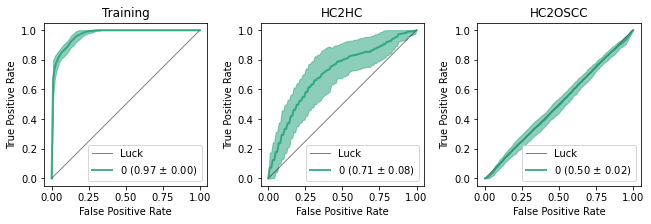

In [437]:
fig, (ax_train, ax_test, ax_oscc) = plt.subplots(nrows=1, ncols=3, 
                                                 figsize=(11, 3))
for ax, df, title in zip([ax_train, ax_test, ax_oscc],
                         [res_hc_train, res_hc_test, res_oscc],
                         labels):
    ca.training.plot_roc(df, classes=[0], ax=ax, title=title)
# plt.savefig('figures-and-tables/gender-prediction-roc-curve.pdf',
#             bbox_inches='tight')